In [1]:
pip install tensorflow tf-keras-vis matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [3]:
df = pd.read_csv("IoT_dataset.csv", low_memory=False)
print(df['Attack_type'].value_counts())

Attack_type
Normal                   24301
DDoS_UDP                 14498
DDoS_ICMP                14090
Ransomware               10925
DDoS_HTTP                10561
SQL_injection            10311
Uploading                10269
DDoS_TCP                 10247
Backdoor                 10195
Vulnerability_scanner    10076
Port_Scanning            10071
XSS                      10052
Password                  9989
MITM                      1214
Fingerprinting            1001
Name: count, dtype: int64


In [4]:
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
y = df['Attack_type']
X = df.drop(['Attack_type'], axis=1)

PCA reduces the CNN accuracy here.

In [5]:
# preprocessing for CNN
labels = df.pop('Attack_type') 

# Variance Threshold : Remove features with low variance
selector = VarianceThreshold(threshold=0.01)
df = selector.fit_transform(df)

# SMOTE for class balance
smote = SMOTE(random_state=42)
data_resampled, labels_resampled = smote.fit_resample(df, labels)
label_encoder = LabelEncoder()
labels_resampled = label_encoder.fit_transform(labels_resampled)
n_features = data_resampled.shape[1]
square_dim = int(np.ceil(np.sqrt(n_features)))

# Pad data to ensure square dimensions
if square_dim * square_dim > n_features:
    padding = np.zeros((data_resampled.shape[0], square_dim * square_dim - n_features))
    data_resampled = np.hstack((data_resampled, padding))
data_reshaped = data_resampled.reshape(data_resampled.shape[0], square_dim, square_dim, 1)

num_classes = len(np.unique(labels_resampled))
if num_classes > 2:
    labels_resampled = to_categorical(labels_resampled)

X_train, X_test, y_train, y_test = train_test_split(data_reshaped, labels_resampled, test_size=0.2, random_state=42, stratify=labels_resampled)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

Using MaxPooling2D in the early layers and Dropout in the later layers of a Convolutional Neural Network (CNN):

### MaxPooling2D in Early Layers
- **Dimensionality Reduction**: MaxPooling2D helps in reducing the spatial dimensions (width and height) of the input volume, which decreases the number of parameters and computations in the network, making it more efficient.
- **Translation Invariance**: Provides a form of translation invariance, meaning the network becomes less sensitive to the exact position of features in the input image.
- **Feature Extraction**: By focusing on the most prominent features, MaxPooling2D helps in extracting the most important features from the input data, which can be useful for the subsequent layers.

### Dropout in Later Layers
- **Prevent Overfitting**: Dropout is a regularization technique that helps in preventing overfitting by randomly setting a fraction of input units to 0 at each update during training time. This forces the network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.
- **Improved Generalization**: By preventing overfitting, Dropout helps in improving the generalization of the model to new, unseen data.

In [6]:
# model architecture
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(square_dim, square_dim, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes if num_classes > 2 else 1, activation='softmax' if num_classes > 2 else 'relu')
])

# model = Sequential([
#     Conv2D(32, kernel_size=(3, 3), activation='sigmoid', input_shape=(square_dim, square_dim, 1)),
#     Dropout(0.25),
#     Conv2D(64, kernel_size=(3, 3), activation='relu'),
#     Dropout(0.25),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(num_classes if num_classes > 2 else 1, activation='softmax' if num_classes > 2 else 'sigmoid')
# ])

loss_function = 'categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy'
model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])
print("Training the model...")
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2, verbose=1)
model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {model_accuracy * 100:.2f}%")

c:\Users\santr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the model...
Epoch 1/10
7291/7291 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.8845 - loss: 0.3658 - val_accuracy: 0.9861 - val_loss: 0.0352
Epoch 2/10
7291/7291 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.9863 - loss: 0.0386 - val_accuracy: 0.9907 - val_loss: 0.0234
Epoch 3/10
7291/7291 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.9896 - loss: 0.0290 - val_accuracy: 0.9933 - val_loss: 0.0155
Epoch 4/10
7291/7291 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.9914 - loss: 0.0231 - val_accuracy: 0.9943 - val_loss: 0.0142
Epoch 5/10
7291/7291 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.9918 - loss: 0.0262 - val_accuracy: 0.9956 - val_loss: 0.0111
Epoch 6/10
7291/7291 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9931 - loss: 0.0502 - val_accuracy: 0.9950 - val_loss: 0.0118
Epoch 7/10
7291/7291 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9929 - loss: 0.0191 - val_accuracy: 0.9950 - val_loss: 0.0118
Epoch 8/10
7291/7291 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accu

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,943 (628.69 KB)

 Trainable params: 53,647 (209.56 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 107,296 (419.13 KB)

In [8]:
model.save('cnn_model.h5')

#### LRP Heatmap Interpretation
- **High-Intensity Regions** (e.g., Bright or Red): Areas where the model found significant features related to the class. 
- **Low-Intensity Regions** (e.g., Dark or Blue): Areas contributing little to the classification and may correspond to background elements or less distinctive parts of the class.

The output feature map from the last convolutional layer before the final dense layer (often used for classification) has dimensions of 7x7 with the series of convolutional and max-pooling layers progressively downsampling the input dimensions.

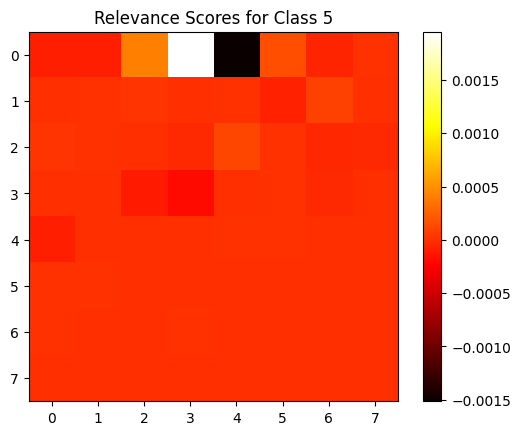

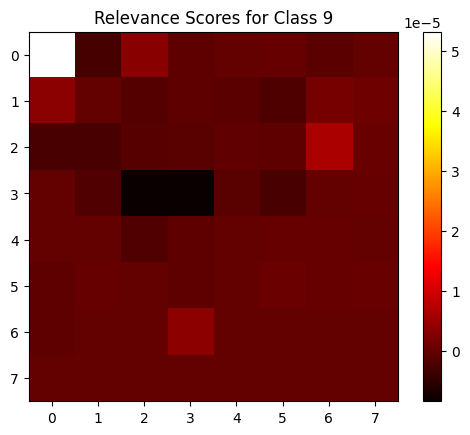

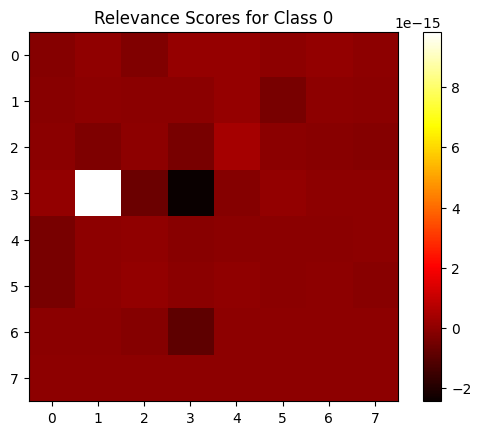

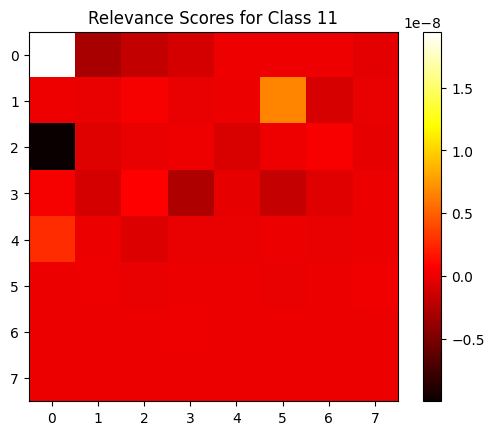

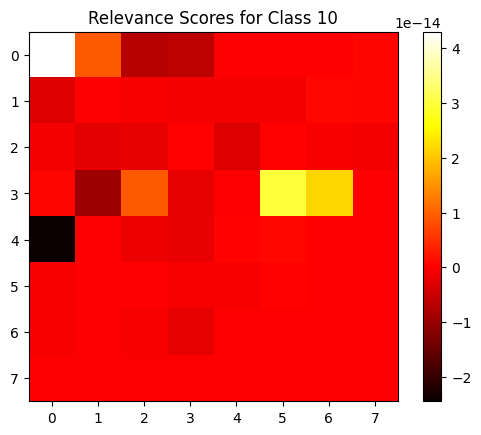

In [9]:
# Define LRP function using gradient backpropagation
def compute_lrp(model, X, target_class_index):
    with tf.GradientTape(persistent=True) as tape:
        inputs = tf.cast(X, tf.float32)
        tape.watch(inputs)
        predictions = model(inputs)
        # gradients for the target class
        target_output = predictions[:, target_class_index]
    
    # gradients of the output with respect to the input and multiply with input to get relevance scores
    grads = tape.gradient(target_output, inputs)
    relevance = inputs * grads
    return relevance.numpy()

# total_samples = X_test.shape[0] 
# loop through all samples
total_samples = 5
for i in range(total_samples):
    test_input = np.expand_dims(X_test[i], axis=0)
    target_class_index = np.argmax(y_test[i]) if y_test.ndim > 1 else y_test[i]
    relevance_scores = compute_lrp(model, test_input, target_class_index)
    plt.imshow(relevance_scores[0, :, :, 0], cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Relevance Scores for Class {target_class_index}')
    plt.show()

Using GradCAM

In [10]:
# import keras
# from tf_keras_vis.gradcam import Gradcam
# from tensorflow.keras.models import Model
# from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
# from tf_keras_vis.utils.scores import CategoricalScore
# from tf_keras_vis.activation_maximization import ActivationMaximization

# # model(X_test[:1])
# grad_model = keras.models.Model(
#     [model.inputs],
#     [model.get_layer('conv2d_1').output,
#     model.get_layer('dense_1').output])
# gradcam = Gradcam(grad_model,
#                   model_modifier=ReplaceToLinear(),
#                   clone=True)

# # Apply DeepLIFT using tf-keras-vis Gradcam for visualization
# score = [CategoricalScore([1]), CategoricalScore([1])]  # Target the positive class (adjust index if needed)
# cam = gradcam(score, test_input, penultimate_layer=-1)  # Penultimate layer to visualize relevance

# # Plot the DeepLIFT relevance heatmap
# heatmap = np.uint8(255 * cam[0])
# plt.imshow(heatmap, cmap='viridis')
# plt.colorbar()
# plt.show()